## Preprocess data

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, median, variance, stdev
from fractions import Fraction
import re

### Useful functions

In [26]:

# Gets modifier value for each stat
def getModifier(stat, baseModifier=-5, startingStat=1, highestStat=30):
    modifier = baseModifier
    # if stat is equal to the base value return base modifier
    if stat == startingStat: return modifier

    # increment modifier by 1
    modifier += 1
    # Loop through all possible stat values and return the corresponding modifier value
    for i in range(2, highestStat):
        # if stat is between these values return the related modifier
        if stat >= i and stat <= i + 1: return modifier
        if not i % 2 == 1: modifier += 1
    return modifier

def convertToFloat(val):
    if type(val) == str:
        return float(Fraction(val))
    else:
        return float(val)

In [130]:
# Get data
dfWin = pd.read_csv("./DataFrames/Winners.csv", index_col=0)
dfLose = pd.read_csv("./DataFrames/Losers.csv", index_col=0)
dfWin.head()

,name,desc,cr,immunities,resists,conditions,wins,actions,hp,str,dex,con,int,wis,cha,ac,spd
0,Wraith of Ogre Power,Medium Undead Neutral Evil,5,"Necrotic,Poison,Charmed,Exhaustion,Grappled,Pa...","Acid,Cold,Fire,Lightning,Thunder,Bludgeoning,P...",Gauntlets of Ogre Power,"Werebear, Air Elemental, Troll, Roper, CR 5","Life Drain: +11, 4d8+9 Necrotic & Life Drain",39,19,16,16,12,14,15,13,60
1,Oni,Large Giant Lawful Evil,7,NaN,NaN,"Death Defying,Regeneration",NaN,"Glaive: +6, 10ft, 2d10+4 Slashing\tMultiattack...",55,19,11,16,14,12,15,16,30
2,Giant Ape,Huge Beast Unaligned,7,NaN,NaN,Shielded,NaN,"Fist: +8, 10ft, 3d10+6 Bludgeoning\tRock: +8, ...",69,23,14,18,7,12,7,12,40
3,Young Brass Dragon,Large Dragon Chaotic Good,6,Fire,NaN,Reliable Damage,NaN,"Multiattack: 10ft, Bite, 2 Claw\tBite: +6, 10f...",61,19,10,17,12,11,15,17,80
4,Fire Elemental,Large Elemental Neutral,5,"Fire,Poison,Exhaustion,Grappled,Paralyzed,Petr...","Bludgeoning,Piercing,Slashing","+2 CHA,Heated Body",NaN,"Touch: +5, 2d6+3 Fire, On Fire\tMultiattack: F...",46,10,17,16,6,10,9,13,50


#### Compare data distribution

Mean: -0.04272959183673469
 Median: 0.0
StdDev: 3.574688361951265


[]

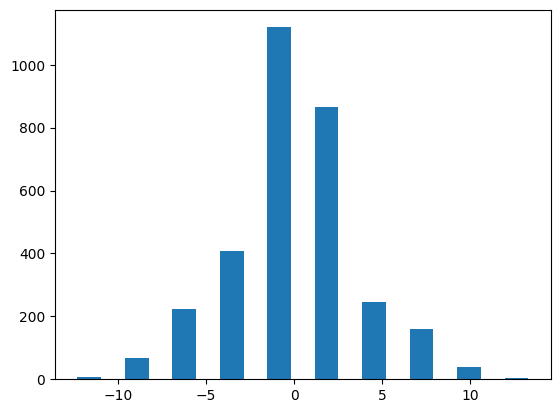

In [185]:
def convertCRToFloat(row):
    return convertToFloat(row)

def getLength(row: str):
    if row != row:
        return 0
    vals = row.split(',')
    return len(vals)

dfWin['cr'] = dfWin.apply(lambda row: convertCRToFloat(row['cr']), axis=1)
dfLose['cr'] = dfLose.apply(lambda row: convertCRToFloat(row['cr']), axis=1)
# Due to an error in cr a few data points have 



dfWin['winlen'] = dfWin.apply(lambda row: getLength(row['wins']), axis=1)
dfLose['winlen'] = dfLose.apply(lambda row: getLength(row['wins']), axis=1)

def findDifference(dfWin: pd.DataFrame, dfLose: pd.DataFrame, stat):
    for (index, rWin), (_, rLose) in zip(dfWin.iterrows(), dfLose.iterrows()):
        # If a stat is greater than a believable amount make the stat equal to its opponent
        # This allows for better generalization of the data
        if rWin[stat] >= 900: rWin[stat] = rLose[stat]
        if rLose[stat] >= 900: rLose[stat] = rWin[stat]
        # Return list of all stats
        yield rWin[stat] - rLose[stat]



dif = list(findDifference(dfWin, dfLose, 'wis'))



print(f"Mean: {mean(dif)}\n Median: {median(dif)}\nStdDev: {stdev(dif)}")
plt.hist(dif, rwidth=0.5)
plt.plot()

[]

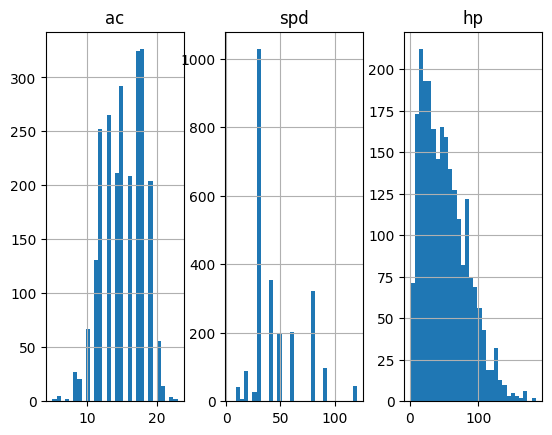

In [155]:
# Compare HP
fig, axes = plt.subplots(1,3)
dfWin.hist(['ac', 'spd', 'hp'], bins=30, ax=axes)
plt.plot()

[]

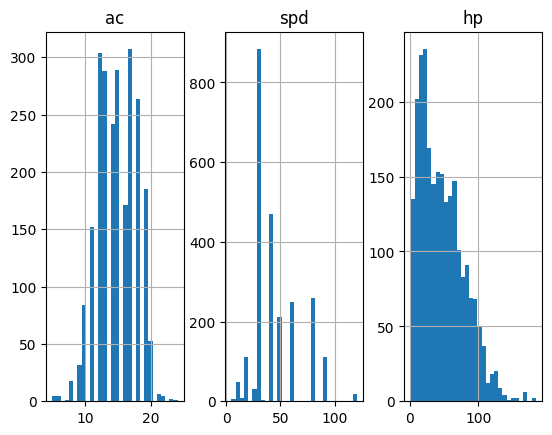

In [156]:
fig, axes = plt.subplots(1,3)
dfLose.hist(['ac', 'spd', 'hp'], bins=30, ax=axes)
plt.plot()

In [95]:
# Code to extract expected damage value per turn of each creature
# TODO: Finish code and refine regex


def getActions(row):
    # Get regex patterns
    
    # Action name
    patName = ':' 
    patMod = r'(\d+),'
    patVals = r'(\d+)(d)(\d+)(\+)(\d+)|(\d+)(d)(\d+)'
    patEffects = r'(Slashing|Piercing|Bludgeoning|Poison|Acid|Fire|Cold|Radiant|Necrotic|Lightning|Thunder|Force|Psychic)'
    patConds = r'(Blinded|Charmed|Deafened|Frightened|Grappled|Incapacitated|Invisible|Paralyzed|Petrified|Poisoned|Prone|Psychic|Restrained|Stunned|Unconscious|Exhaustion)'

    # Seperate all actions into seperate values
    actions = row.split('\t')

    return actions



actions = dfWin.apply(lambda row: getActions(row["actions"]), axis=1)

print(actions.to_numpy())

[list(['Life Drain: +11, 4d8+9 Necrotic & Life Drain'])
 list(['Glaive: +6, 10ft, 2d10+4 Slashing', 'Multiattack: 10ft, 2 Glaive', 'Charm Person: 30ft, Charmed (WIS Save) (If Humanoid)', 'Sleep: 90ft, Asleep (WIS Save)', 'Cone of Cold: 60ft, 8d8 Cold (CON Save)'])
 list(['Fist: +8, 10ft, 3d10+6 Bludgeoning', 'Rock: +8, 50ft, 7d6+6 Bludgeoning', 'Multiattack: 10ft, 2 Fist', 'Shield: +5 to AC, Reaction'])
 ...
 list(['Multiattack: Bite, Claws, Horns', 'Breath Weapon Combo: 15ft, Fire Breath, Bite, Claws', 'Bite: +1, 2d6+20 Piercing', 'Horns: +1, 1d12+20 Bludgeoning', 'Claws: +1, 2d6+20 Slashing', 'Fire Breath: 15ft, 7d8 Fire (DEX Save)'])
 list(['Charm: 30ft, Charmed (WIS Save) (If Humanoid)', 'Bite: +8, 1d6+4 Piercing, 3d6 Necrotic & Vampirism (If Grappled & Restrained)', 'Unarmed Strike: +8, 1d8+4 Bludgeoning (If Grappled & Restrained), Grappled & Restrained (If Not Grappled & Restrained)', 'Multiattack: Unarmed Strike, Bite, Unarmed Punch', 'Multistrike: 2 Unarmed Strike'])
 list(['Fl

In [40]:


actions = {"name": [], "modifier": [], "vals": [], "effects": [], "conditions": []}
action = "Shortsword: +3, 1d16+1 Piercing, Sneak Attack"
valsPat1 = r",\s*(-?\d+(?:\.\d+)?)\s*(?:\w+\s*)*,"
valsPat2 = r'(\d+)(d)(\d+)(\+)(\d+)|(\d+)(d)(\d+)'
name = action.split(':')[0]
modifier = re.findall(r':\s*(-?\+?\d+),', action)
vals = re.findall(valsPat2, action)
effects = re.findall(r'(Slashing|Piercing|Bludgeoning|Poison|Acid|Fire|Cold|Radiant|Necrotic|Lightning|Thunder|Force|Psychic)', action)
conditions = re.findall(r'(Blinded|Charmed|Deafened|Frightened|Grappled|Incapacitated|Invisible|Paralyzed|Petrified|Poisoned|Prone|Psychic|Restrained|Stunned|Unconscious|Exhaustion)', action)

# Append all values
actions["name"].append(name)
actions["modifier"].append(modifier)
actions["vals"].append(vals)
actions["effects"].append(effects)
actions["conditions"].append(conditions)


print(vals)

[('1', 'd', '16', '+', '1', '', '', '')]
